100%|██████████| 26421880/26421880 [00:04<00:00, 5948037.23it/s] 


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 297572.41it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2973697.80it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 8225629.33it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Number of training samples: 60000
Epoch [0/100] Batch [0/938] Loss D: 0.6880438327789307, loss G: 0.686906635761261
Epoch [0/100] Batch [100/938] Loss D: 0.16669774055480957, loss G: 1.6092288494110107
Epoch [0/100] Batch [200/938] Loss D: 0.025156617164611816, loss G: 3.5318081378936768
Epoch [0/100] Batch [300/938] Loss D: 0.5815755724906921, loss G: 0.8779314756393433
Epoch [0/100] Batch [400/938] Loss D: 0.10255800932645798, loss G: 4.115534782409668
Epoch [0/100] Batch [500/938] Loss D: 0.012445064261555672, loss G: 4.4061598777771
Epoch [0/100] Batch [600/938] Loss D: 0.06779323518276215, loss G: 2.9271509647369385
Epoch [0/100] Batch [700/938] Loss D: 0.11164874583482742, loss G: 3.9904613494873047
Epoch [0/100] Batch [800/938] Loss D: 0.02330118976533413, loss G: 5.315925121307373
Epoch [0/100] Batch [900/938] Loss D: 0.022998861968517303, loss G: 4.50042724609375
Epoch [1/100] Batch [0/938

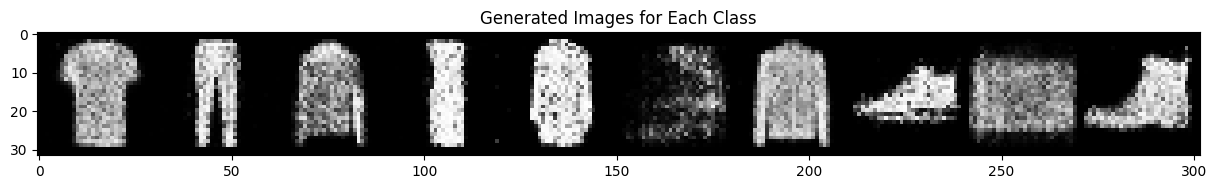

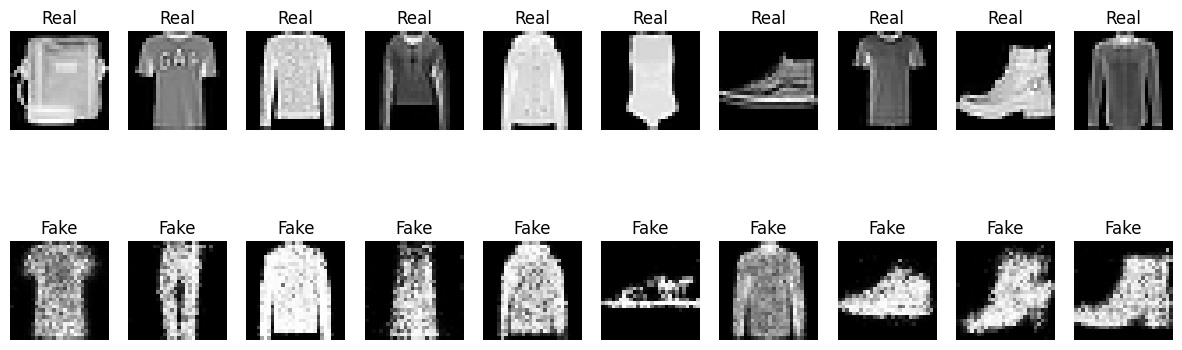

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

# **Data Preprocessing
# Load the Fashion MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
combined_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(combined_dataset, batch_size=64, shuffle=True)

# Print the number of training samples
print(f"Number of training samples: {len(combined_dataset)}")



# **Generator Architecture
class Generator(nn.Module):
    def __init__(self, z_dim, label_dim, img_dim):
        super(Generator, self).__init__()
        self.label_embedding = nn.Embedding(label_dim, label_dim) #creates an embedding layer that converts labels(like shirt or shoe)
        # into the format model can use
        self.model = nn.Sequential( #sequential helps stack the layers in order so the data flows from one to next
            nn.Linear(z_dim + label_dim, 128),
            nn.ReLU(), #A fn that introduces non linearity,helping the model learn more complex patterns
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, img_dim),
            nn.Tanh() #Ensures the output values are between -1 and 1, which helps in image generation.
        )

    def forward(self, z, labels):  #Defines how the input data (random noise z and labels) pass through the network.
        # Concatenate the noise vector and the label embedding
        c = self.label_embedding(labels)
        x = torch.cat([z, c], dim=1)   #Combines the random noise z and the embedded labels c into a single input. This is necessary because the model needs both pieces of information to generate an image.
        # Generate an image from the concatenated input
        img = self.model(x)  # Passes the combined input through the model (the sequence of layers defined earlier) to generate an image.
        img = img.view(img.size(0), 1, 28, 28)  #Reshapes the output so that it looks like an image (with 1 channel and 28x28 pixels)
        return img



# **Discriminator Architecture
class Discriminator(nn.Module):
    def __init__(self, img_dim, label_dim):
        super(Discriminator, self).__init__()
        self.label_embedding = nn.Embedding(label_dim, label_dim)
        self.model = nn.Sequential(
            nn.Linear(img_dim + label_dim, 512),
            nn.LeakyReLU(0.2), #A function similar to ReLU but allows for a small gradient when the unit is not active, which helps prevent the model from getting stuck.
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid() #Ensures the output is between 0 and 1, representing the probability of the image being real.
        )

    def forward(self, img, labels):
        # Concatenate the image and the label embedding
        c = self.label_embedding(labels)
        x = torch.cat([img.view(img.size(0), -1), c], dim=1)
        # Compute the validity score of the image
        validity = self.model(x)
        return validity

# Hyperparameters
z_dim = 100  #Size of the random noise vector that will be input to the generator
label_dim = 10 #Number of unique labels or classes in the dataset
img_dim = 28*28 #Size of the image when flattened into a single line of data.
lr = 0.0002
n_epochs = 100

# **Loss function
adversarial_loss = nn.BCELoss() #Binary Cross Entropy Loss. This function measures the difference between the predicted probability (whether an image is real or fake) and the actual
# label. It is used to train both the generator and the discriminator.

# Initialize generator and discriminator
generator = Generator(z_dim, label_dim, img_dim)
discriminator = Discriminator(img_dim, label_dim)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)
#optim.Adam: A type of optimizer that adjusts the model's weights based on the gradients of the loss function. It is an adaptive learning rate optimization algorithm
# These specify which parameters (weights and biases) should be updated by the optimizer.


# **Training Loop
for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(train_loader):
        batch_size = imgs.size(0)

        # Adversarial ground truths
        valid = torch.ones(batch_size, 1) # valid represents labels for real images (all ones)
        fake = torch.zeros(batch_size, 1) #fake represents labels for fake images (all zeros).

        # Configure input
        real_imgs = imgs
        labels = labels

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad() #Resets the gradients for the generator.

        # Sample noise and labels as generator input
        z = torch.randn(batch_size, z_dim)
        gen_labels = torch.randint(0, label_dim, (batch_size,))
        #Generates random noise (z) and random labels (gen_labels) as input for the generator.

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels) # Generates fake images using the generator.

        # Loss measures generator's ability to fool the discriminator
        validity = discriminator(gen_imgs, gen_labels)  #Passes the generated images through the discriminator to get their validity
        g_loss = adversarial_loss(validity, valid) #Calculates the generator's loss by comparing the discriminator's output to the valid labels (all ones).

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad() #Resets the gradients for the discriminator

        # Loss for real images
        real_validity = discriminator(real_imgs, labels) #Passes real images through the discriminator to get their validity
        d_real_loss = adversarial_loss(real_validity, valid) #Calculates the discriminator's loss for real images.

        # Loss for fake images
        fake_validity = discriminator(gen_imgs.detach(), gen_labels)
        d_fake_loss = adversarial_loss(fake_validity, fake)
        #gen_imgs.detach() is used to stop the gradient flow from the discriminator to the generator.

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch}/{n_epochs}] Batch [{i}/{len(train_loader)}] Loss D: {d_loss.item()}, loss G: {g_loss.item()}")

# **Generate conditional samples for different fashion categories and visualize the results
def generate_images(generator, n_samples):
    z = torch.randn(n_samples, z_dim)
    labels = torch.arange(label_dim)
    gen_imgs = generator(z, labels)
    return gen_imgs, labels

gen_imgs, labels = generate_images(generator, label_dim)

# Visualization
grid = make_grid(gen_imgs, nrow=label_dim, normalize=True)
plt.figure(figsize=(15, 15))
plt.imshow(grid.permute(1, 2, 0).detach().cpu().numpy())
plt.title("Generated Images for Each Class")
plt.show()

# **Real vs Fake Visual Analysis
real_imgs, _ = next(iter(train_loader))
real_imgs = real_imgs[:label_dim]
gen_imgs, labels = generate_images(generator, label_dim)

# Plot real vs fake images
# Plot real vs fake images
fig, axes = plt.subplots(2, label_dim, figsize=(15, 5))
for i in range(label_dim):
    axes[0, i].imshow(real_imgs[i].permute(1, 2, 0).squeeze().detach().cpu().numpy(), cmap='gray')
    axes[0, i].set_title("Real")
    axes[0, i].axis('off')
    axes[1, i].imshow(gen_imgs[i].permute(1, 2, 0).squeeze().detach().cpu().numpy(), cmap='gray')
    axes[1, i].set_title("Fake")
    axes[1, i].axis('off')
plt.show()

